In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random, os
import cv2
import plotly.express    as px
from sklearn.utils       import resample

try:
    import opendatasets as od
except:
    !pip install keyring
    import opendatasets as od

from tensorflow import keras
from sklearn.metrics import accuracy_score,confusion_matrix,classification_report

import warnings
warnings.filterwarnings("ignore")

from imblearn.over_sampling import SMOTE
from collections import Counter

# Download data from Kaggle

In [2]:
PATH = 'isic-2019/'
PATH_IMG = 'isic-2019/ISIC_2019_Training_Input/'

if not os.path.exists(PATH_IMG):
    
    od.download("https://www.kaggle.com/datasets/andrewmvd/isic-2019/data/")
    df = pd.read_csv(PATH+'ISIC_2019_Training_GroundTruth.csv')
    print(f'GroundTrunth is now loaded: {df.shape}')
    print(df.head())

    print('\n')
    dfm = pd.read_csv(PATH+'ISIC_2019_Training_Metadata.csv')
    print(f'Meta data is now loaded: {dfm.shape}')
    print(dfm.head())

else:
    print('\nFiles already exist')
    df = pd.read_csv(PATH+'ISIC_2019_Training_GroundTruth.csv')
    print(f'GroundTrunth is now loaded: {df.shape}')
    print(df.head())

    print('\n')
    dfm = pd.read_csv(PATH+'ISIC_2019_Training_Metadata.csv')
    print(f'Meta data is now loaded: {dfm.shape}')
    print(dfm.head())
    


Files already exist
GroundTrunth is now loaded: (25331, 10)
          image  MEL   NV  BCC   AK  BKL   DF  VASC  SCC  UNK
0  ISIC_0000000  0.0  1.0  0.0  0.0  0.0  0.0   0.0  0.0  0.0
1  ISIC_0000001  0.0  1.0  0.0  0.0  0.0  0.0   0.0  0.0  0.0
2  ISIC_0000002  1.0  0.0  0.0  0.0  0.0  0.0   0.0  0.0  0.0
3  ISIC_0000003  0.0  1.0  0.0  0.0  0.0  0.0   0.0  0.0  0.0
4  ISIC_0000004  1.0  0.0  0.0  0.0  0.0  0.0   0.0  0.0  0.0


Meta data is now loaded: (25331, 5)
          image  age_approx anatom_site_general lesion_id     sex
0  ISIC_0000000        55.0      anterior torso       NaN  female
1  ISIC_0000001        30.0      anterior torso       NaN  female
2  ISIC_0000002        60.0     upper extremity       NaN  female
3  ISIC_0000003        30.0     upper extremity       NaN    male
4  ISIC_0000004        80.0     posterior torso       NaN    male


# Image count by categories



In [3]:
cols = list(df.columns[1:])

for i in range(0,len(cols)):
      print("Total images of " + cols[i]+ " : "+ str(len(df[df[cols[i]]>0])))

Total images of MEL : 4522
Total images of NV : 12875
Total images of BCC : 3323
Total images of AK : 867
Total images of BKL : 2624
Total images of DF : 239
Total images of VASC : 253
Total images of SCC : 628
Total images of UNK : 0


**Abbreviations used in the dataset**


<li>
MEL: Melanoma — a malignant neoplasm derived from melanocytes </li>
<li>NV: Melanocytic nevi — benign neoplasms of melanocytes </li>
<li>BCC: Basal cell carcinoma — a common variant of epithelial skin cancer that rarely metastasizes but grows destructively if untreated (bccs do not necessarily produce pigmented lesions)</li>
<li>AK: Actinic Keratoses and intraepithelial Carcinoma — common non-invasive, variants of squamous cell carcinoma that can be treated locally without surgery</li>
<li>BKL: Benign keratosis — a generic class that includes seborrheic keratoses, solar lentigo and lichen-planus like keratoses</li>
<li>DF: Dermatofibroma — a benign skin lesion regarded as either a benign proliferation or an inflammatory reaction to minimal trauma</li>
<li>VASC: Vascular skin lesions ranging from cherry angiomas to angiokeratomas and pyogenic granulomas</li>
<li>SCC: Squamous cell carcinoma — a common form of skin cancer that develops in the squamous cells that make up the middle and outer layers of the skin</li>
<li>UNK: None of the others
</li>

# Drop UNK Column

In [4]:
df = df.iloc[:,:-1]
print(df.shape)
df.head()

(25331, 9)


,image,MEL,NV,BCC,AK,BKL,DF,VASC,SCC
0,ISIC_0000000,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1,ISIC_0000001,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2,ISIC_0000002,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,ISIC_0000003,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,ISIC_0000004,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# convert float to integer

In [5]:
df_1 = df.iloc[:,:1]
df_2 = df.iloc[:,1:].astype('int')

dft = pd.merge(df_1,df_2,left_index=True, right_index=True)
dft.head()

,image,MEL,NV,BCC,AK,BKL,DF,VASC,SCC
0,ISIC_0000000,0,1,0,0,0,0,0,0
1,ISIC_0000001,0,1,0,0,0,0,0,0
2,ISIC_0000002,1,0,0,0,0,0,0,0
3,ISIC_0000003,0,1,0,0,0,0,0,0
4,ISIC_0000004,1,0,0,0,0,0,0,0


# Create a new dataframe contains a target column 

In [6]:
for column in dft:
    dft[column] = dft[column].astype(str).replace("1", column)
    
# dft.head()

dft.replace('0', np.nan, inplace=True)
dft['target'] = dft[dft.columns[1:]].apply(
    lambda x: ','.join(x.dropna().astype(str)),
    axis=1
)

dft = pd.merge(dft.iloc[:,:1],dft.iloc[:,-1:],left_index=True, right_index=True)
dft.head()

,image,target
0,ISIC_0000000,NV
1,ISIC_0000001,NV
2,ISIC_0000002,MEL
3,ISIC_0000003,NV
4,ISIC_0000004,MEL


# show unique value by each column

In [7]:
for i in dfm.columns[1:]:
    print(i)
    print(dfm[i].unique())
    print('\n')
    print('/'*60)

age_approx
[55. 30. 60. 80. 25. 35. 50. 45. 70. 40. 65. 20. 15. 85. nan  5. 10. 75.
  0.]


////////////////////////////////////////////////////////////
anatom_site_general
['anterior torso' 'upper extremity' 'posterior torso' 'lower extremity'
 nan 'lateral torso' 'head/neck' 'palms/soles' 'oral/genital']


////////////////////////////////////////////////////////////
lesion_id
[nan 'MSK4_0011169' 'MSK4_0011170' ... 'BCN_0002147' 'BCN_0001946'
 'BCN_0001014']


////////////////////////////////////////////////////////////
sex
['female' 'male' nan]


////////////////////////////////////////////////////////////


# Check if there is any missing values

In [8]:
for i in dfm.columns[1:]:
    print('There is {} missing in column {} which is {:.0%} missing value'.format(dfm[i].isna().sum(),i,dfm[i].isna().sum()/len(dfm)))
    print('\n')
    print('/'*60)

There is 437 missing in column age_approx which is 2% missing value


////////////////////////////////////////////////////////////
There is 2631 missing in column anatom_site_general which is 10% missing value


////////////////////////////////////////////////////////////
There is 2084 missing in column lesion_id which is 8% missing value


////////////////////////////////////////////////////////////
There is 384 missing in column sex which is 2% missing value


////////////////////////////////////////////////////////////


# change records if gender is missing to UNK

In [9]:
dfm['sex'] = dfm['sex'].fillna('unk')
dfm.sex.value_counts()

male      13286
female    11661
unk         384
Name: sex, dtype: int64

# drop if age_approx is missing


In [10]:
# training
df.drop(dfm[dfm.age_approx.isna()].index, inplace =True)
df.shape

(24894, 9)

In [11]:
# Target table
dft.drop(dfm[dfm.age_approx.isna()].index, inplace =True)
dft.shape

(24894, 2)

In [12]:
# metadata
dfm.drop(dfm[dfm.age_approx.isna()].index, inplace =True)
dfm.shape

(24894, 5)

# Visualization

In [13]:
def plot_count(df, feature, title='', size=2, rotate_axis = False):
    f, ax = plt.subplots(1,1, figsize=(3*size,2*size))
    total = float(len(df))
    sns.countplot(df[feature],order = df[feature].value_counts().index, palette="crest")
    plt.title(title)
    if(rotate_axis):
        ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
    for p in ax.patches:
        height = p.get_height()
        ax.text(p.get_x()+p.get_width()/2.,
                height + 3,
                '{:1.2f}%'.format(100*height/total),
                ha="center") 
    plt.show()

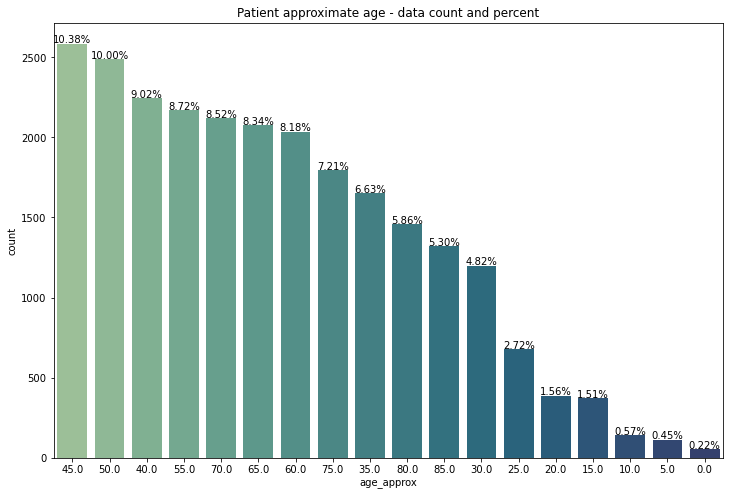

In [14]:

plot_count(dfm, 'age_approx', 'Patient approximate age - data count and percent', size=4)

# Visualize categorical flow between melanoma vs others

In [15]:
df_plot = pd.concat([dft,dfm], axis = 1)
# drop columns (image and id)
df_plot.drop(columns = ['image','lesion_id'], inplace = True)
df_plot['melanoma'] = df_plot['target'].apply(lambda x: 1 if x == 'MEL' else 0)
df_plot.head()

,target,age_approx,anatom_site_general,sex,melanoma
0,NV,55.0,anterior torso,female,0
1,NV,30.0,anterior torso,female,0
2,MEL,60.0,upper extremity,female,1
3,NV,30.0,upper extremity,male,0
4,MEL,80.0,posterior torso,male,1


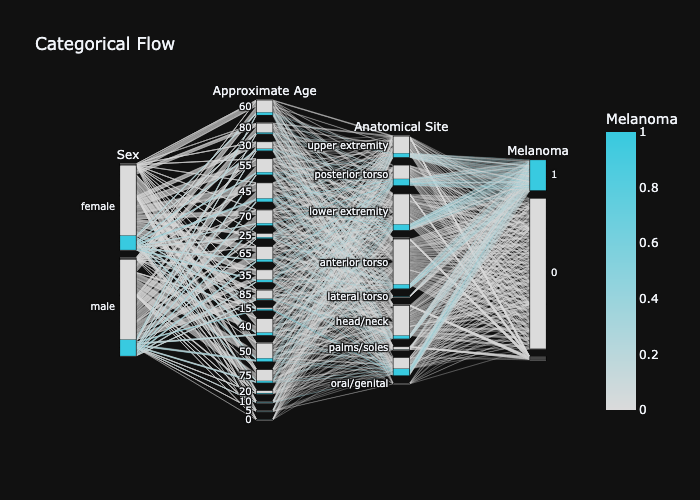

In [16]:
parallel_df = df_plot.copy()

undersampled_df = pd.concat([parallel_df.query("melanoma == 1"),resample(parallel_df.query("melanoma == 0"),
                                                                       replace   = False,
#                                                                        n_samples = 584,
                                                                       random_state = 451)
                            ],axis=0)


keep_list = ['sex','age_approx','anatom_site_general','melanoma']
fig = px.parallel_categories(undersampled_df[keep_list],
                              color="melanoma",
                              template='plotly_dark',
                              labels={"age_approx": "Approximate Age","sex": "Sex", 'anatom_site_general':'Anatomical Site','melanoma':'Melanoma'},
                              color_continuous_scale=['#dbdbdb','#38cae0'],
                              title='Categorical Flow'
                             )

fig.update_layout(showlegend=False)
fig.show("png")

# Create dummy category for anatom_site_general and sex

In [17]:
print(dfm['anatom_site_general'].value_counts())
dfm_cat = pd.get_dummies(dfm[['anatom_site_general','sex']])
dfm_cat.head()

anterior torso     6836
lower extremity    4958
head/neck          4576
upper extremity    2877
posterior torso    2736
palms/soles         393
oral/genital         59
lateral torso        45
Name: anatom_site_general, dtype: int64


,anatom_site_general_anterior torso,anatom_site_general_head/neck,anatom_site_general_lateral torso,anatom_site_general_lower extremity,anatom_site_general_oral/genital,anatom_site_general_palms/soles,anatom_site_general_posterior torso,anatom_site_general_upper extremity,sex_female,sex_male
0,1,0,0,0,0,0,0,0,1,0
1,1,0,0,0,0,0,0,0,1,0
2,0,0,0,0,0,0,0,1,1,0
3,0,0,0,0,0,0,0,1,0,1
4,0,0,0,0,0,0,1,0,0,1


# create a new data frame for model

In [18]:
df_clean = pd.concat([dft,dfm[['age_approx']],dfm_cat], axis = 1)
print(df_clean.shape)
df_clean.head()

(24894, 13)


,image,target,age_approx,anatom_site_general_anterior torso,anatom_site_general_head/neck,anatom_site_general_lateral torso,anatom_site_general_lower extremity,anatom_site_general_oral/genital,anatom_site_general_palms/soles,anatom_site_general_posterior torso,anatom_site_general_upper extremity,sex_female,sex_male
0,ISIC_0000000,NV,55.0,1,0,0,0,0,0,0,0,1,0
1,ISIC_0000001,NV,30.0,1,0,0,0,0,0,0,0,1,0
2,ISIC_0000002,MEL,60.0,0,0,0,0,0,0,0,1,1,0
3,ISIC_0000003,NV,30.0,0,0,0,0,0,0,0,1,0,1
4,ISIC_0000004,MEL,80.0,0,0,0,0,0,0,1,0,0,1


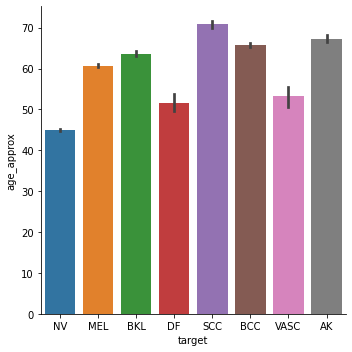

In [19]:
ax = sns.catplot(x="target",y="age_approx",data=df_clean,kind='bar')

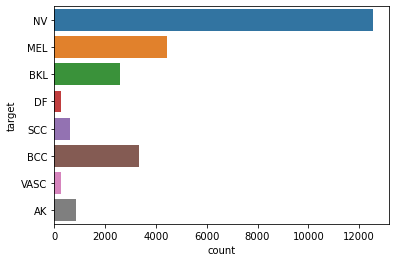

In [20]:
ax = sns.countplot(y="target",data=df_clean)


# NearMiss Algorithm – Undersampling
`NearMiss` is an under-sampling technique. It aims to balance class distribution by randomly eliminating majority class examples. When instances of two different classes are very close to each other, we remove the instances of the majority class to increase the spaces between the two classes. This helps in the classification process.
To prevent problem of information loss in most under-sampling techniques, `near-neighbor` methods are widely used.

# Pre-processing for model

In [21]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn import preprocessing
from imblearn.under_sampling import NearMiss


X = df_clean.drop(columns = ['image','target'])
y = df_clean.target

# data pre-processing using normalizer
X = preprocessing.Normalizer().fit(X).transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0,stratify=y)

nr = NearMiss()
X_train, y_train = nr.fit_resample(X_train, y_train.ravel())

print(X_train.shape,  X_test.shape)

(1528, 11) (4979, 11)


In [22]:
Counter(y_train)

Counter({'AK': 191,
         'BCC': 191,
         'BKL': 191,
         'DF': 191,
         'MEL': 191,
         'NV': 191,
         'SCC': 191,
         'VASC': 191})

# Implementing a Naive Bayes classifier

The Naive Bayes classification algorithm is a probabilistic classifier, and it belongs to Supervised Learning. It is based on probability models that incorporate strong independence assumptions. The independence assumptions often do not have an impact on reality. Therefore they are considered naive.

In [23]:
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import (accuracy_score, 
                             precision_score,
                             recall_score, 
                             f1_score)
nb=GaussianNB()

In [24]:
nb.fit(X_train,y_train)
y_pred_nb=nb.predict(X_test)

In [25]:
print('Model accuracy score: {0:0.4f}'. format(accuracy_score(y_test, y_pred_nb)))
print('\n')
print(classification_report(y_test,y_pred_nb))

Model accuracy score: 0.1575


              precision    recall  f1-score   support

          AK       0.01      0.05      0.02       173
         BCC       0.14      0.11      0.13       663
         BKL       0.06      0.01      0.02       520
          DF       0.01      0.02      0.01        48
         MEL       0.20      0.04      0.06       887
          NV       0.83      0.23      0.37      2512
         SCC       0.06      0.48      0.11       126
        VASC       0.01      0.22      0.01        50

    accuracy                           0.16      4979
   macro avg       0.17      0.15      0.09      4979
weighted avg       0.48      0.16      0.22      4979



In [26]:
l = ['AK','BCC','BKL','DF','MEL','NV','SCC','VASC']

Text(91.68, 0.5, 'predicted label')

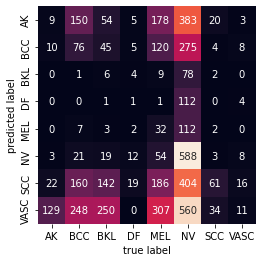

In [27]:
from sklearn.metrics import confusion_matrix
labels = nb.predict(X_test)
mat = confusion_matrix(y_test, labels)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=l, yticklabels=l)
plt.xlabel('true label')
plt.ylabel('predicted label')

In [36]:
# y_train.unique()

# Multinomial Naive Bayes

The Gaussian assumption just described is by no means the only simple assumption that could be used to specify the generative distribution for each label. Another useful example is multinomial naive Bayes, where the features are assumed to be generated from a simple multinomial distribution. The multinomial distribution describes the probability of observing counts among a number of categories, and thus multinomial naive Bayes is most appropriate for features that represent counts or count rates.

The idea is precisely the same as before, except that instead of modeling the data distribution with the best-fit Gaussian, we model the data distribuiton with a best-fit multinomial distribution.

In [28]:
from sklearn.naive_bayes import MultinomialNB
mnb = MultinomialNB()
mnb.fit(X_train,y_train)

y_pred_mnb=mnb.predict(X_test)
print(accuracy_score(y_pred_mnb,y_test))
print(classification_report(y_test,y_pred_mnb))

0.08817031532436233
              precision    recall  f1-score   support

          AK       0.01      0.12      0.03       173
         BCC       0.10      0.16      0.12       663
         BKL       0.00      0.00      0.00       520
          DF       0.00      0.00      0.00        48
         MEL       0.18      0.01      0.02       887
          NV       0.78      0.10      0.18      2512
         SCC       0.04      0.33      0.07       126
        VASC       0.01      0.14      0.01        50

    accuracy                           0.09      4979
   macro avg       0.14      0.11      0.05      4979
weighted avg       0.44      0.09      0.11      4979



Text(91.68, 0.5, 'predicted label')

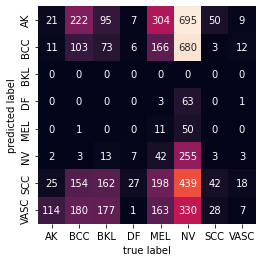

In [29]:
from sklearn.metrics import confusion_matrix
labels = mnb.predict(X_test)
mat = confusion_matrix(y_test, labels)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=l, yticklabels=l)
plt.xlabel('true label')
plt.ylabel('predicted label')

# ComplementNB

The Complement Naive Bayes classifier was designed to correct the “severe assumptions” made by the standard Multinomial Naive Bayes classifier. It is particularly suited for imbalanced data sets.

In [30]:
from sklearn.naive_bayes import ComplementNB
cnb = ComplementNB()
cnb.fit(X_train, y_train)

y_pred_cnb=cnb.predict(X_test)

In [31]:
print(accuracy_score(y_pred_cnb,y_test))
print(classification_report(y_pred_cnb,y_test))

0.10202851978308898
              precision    recall  f1-score   support

          AK       0.09      0.02      0.03       915
         BCC       0.14      0.11      0.12       843
         BKL       0.00      0.00      0.00         0
          DF       0.19      0.04      0.06       231
         MEL       0.00      0.00      0.00         6
          NV       0.14      0.63      0.23       566
         SCC       0.17      0.08      0.11       263
        VASC       0.34      0.01      0.02      2155

    accuracy                           0.10      4979
   macro avg       0.13      0.11      0.07      4979
weighted avg       0.22      0.10      0.07      4979



Text(91.68, 0.5, 'predicted label')

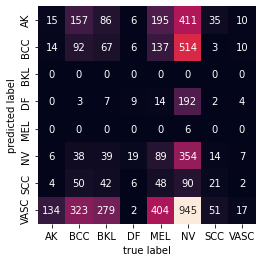

In [32]:
labels = cnb.predict(X_test)
mat = confusion_matrix(y_test, labels)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=l, yticklabels=l)
plt.xlabel('true label')
plt.ylabel('predicted label')

# When to use Naive Bayes Classifier?
Naive Bayes classifiers tend to perform especially well in any of the following situations:

When the naive assumptions actually match the data.
For very well-separated categories, when model complexity is less important.
And for very high-dimensional data, when model complexity is again less important.
The last two points appear unrelated, but they are related to each other. As a dataset’s dimension grows, it becomes considerably less likely that any two points will be discovered near together. This means that clusters in high dimensions tend to be more separated than clusters in low dimensions,

The Naive Bayes classifier has the following advantages.

Naive Bayes classification is extremely fast for both training and prediction.
It provides straightforward probabilistic prediction.
Naive Bayes has a very low computation cost.
It can efficiently work on a large dataset.
It performs well in the case of discrete response variables compared to the continuous variable.
It can be used with multiple class prediction problems.
It also performs well in the case of text analytics problems.
When the assumption of independence holds, a Naive Bayes classifier performs better compared to other models like Logistic Regression.
Real-life applications using Naive Bayes Classification
The Naive Bayes algorithm offers plenty of advantages to its users. That’s why it has a lot of applications in various industries, including Health, Technology, Environment, etc. Here are a few of the applications of the Naive Bayes classification:

It is used in text classification. For example News on the web is rapidly growing and each news site has its own different layout and categorization for grouping news. In order to achieve better classification results, we apply the naive Bayes classifier for the classification of news contents based on news code.
Another application of Naive Bayes classification is Spam filtering. It typically uses a bag of words features to identify spam e-mail.  Naive Bayes classifiers work by correlating the use of tokens (typically words, or sometimes other things), with spam and non-spam e-mails and then using Bayes’ theorem to calculate the probability that an email is or is not spam.
One of the advantages of the Naive Bayes Classifier is that it takes all the available information to explain the decision. When dealing with medical data, the Naïve Bayes classifier takes into account evidence from many attributes to make the final prediction and provides transparent explanations of its decisions. That is why it has many applications in the health sector as well.
Weather prediction has been a challenging problem in the meteorological department for years. Even after technological and scientific advancements, the accuracy in the prediction of weather has never been sufficient. However, Naive Bayes classifiers give high accuracy results when predicting the weather conditions.
Its assumption of feature independence, and its effectiveness in solving multi-class problems, make it perfect for performing Sentiment Analysis. Sentiment Analysis refers to the identification of positive or negative sentiments of a target group.
Collaborative Filtering and the Naive Bayes algorithm work together to build recommendation systems. These systems use data mining and Machine Learning to predict if the user would like a particular resource or not.

# Logistic Regresstion

## Multi class Logistic Regression Using OVR

In [33]:
from sklearn import linear_model
from sklearn import metrics

In [34]:
lm = linear_model.LogisticRegression(multi_class='ovr', solver='liblinear')
lm.fit(X_train, y_train)\

y_pred_lm=lm.predict(X_test)

In [35]:
print(accuracy_score(y_pred_lm,y_test))
print(classification_report(y_pred_lm,y_test))

0.11427997589877485
              precision    recall  f1-score   support

          AK       0.10      0.02      0.03       937
         BCC       0.16      0.10      0.12      1051
         BKL       0.00      0.00      0.00         0
          DF       0.25      0.04      0.07       307
         MEL       0.04      0.22      0.07       157
          NV       0.15      0.60      0.24       620
         SCC       0.13      0.11      0.12       149
        VASC       0.20      0.01      0.01      1758

    accuracy                           0.11      4979
   macro avg       0.13      0.14      0.08      4979
weighted avg       0.16      0.11      0.08      4979



In [36]:
lm.score(X_test, y_test)

0.11427997589877485

array([[ 17,  14,   0,   0,   1,   7,   3, 131],
       [143, 104,   0,  11,   8,  47,  33, 317],
       [109,  75,   0,  15,   5,  44,  28, 244],
       [  3,   6,   0,  12,   3,  20,   2,   2],
       [208, 173,   0,  21,  35, 101,  28, 321],
       [405, 664,   0, 240, 105, 374,  37, 687],
       [ 39,   4,   0,   3,   0,  17,  17,  46],
       [ 13,  11,   0,   5,   0,  10,   1,  10]])

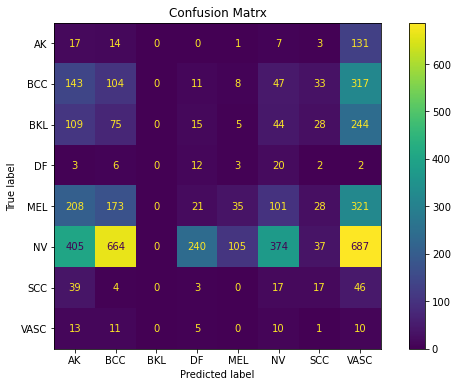

In [37]:
fig, ax = plt.subplots(figsize=(10, 6))
ax.set_title('Confusion Matrx')

disp =metrics.plot_confusion_matrix(lm, X_test, y_test,  ax = ax)
disp.confusion_matrix

In [38]:
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score

In [39]:
model2 = LogisticRegression(solver='lbfgs')
model2.fit(X_train, y_train)\

y_pred_lm2=model2.predict(X_test)

In [40]:
print(accuracy_score(y_pred_lm2,y_test))
print(classification_report(y_pred_lm2,y_test))

0.11427997589877485
              precision    recall  f1-score   support

          AK       0.10      0.02      0.03       927
         BCC       0.16      0.10      0.12      1051
         BKL       0.00      0.00      0.00         0
          DF       0.25      0.04      0.07       307
         MEL       0.04      0.22      0.07       157
          NV       0.15      0.60      0.24       620
         SCC       0.13      0.11      0.12       149
        VASC       0.20      0.01      0.01      1768

    accuracy                           0.11      4979
   macro avg       0.13      0.14      0.08      4979
weighted avg       0.16      0.11      0.07      4979



In [41]:
LogReg = LogisticRegression(C=1, multi_class='multinomial', max_iter=1000)
LogReg.fit(X_train,y_train)

y_pred_lm3=LogReg.predict(X_test)

In [42]:
print(accuracy_score(y_pred_lm3,y_test))
print(classification_report(y_pred_lm3,y_test))

0.11427997589877485
              precision    recall  f1-score   support

          AK       0.10      0.02      0.03       927
         BCC       0.16      0.10      0.12      1051
         BKL       0.00      0.00      0.00         0
          DF       0.25      0.04      0.07       307
         MEL       0.04      0.22      0.07       157
          NV       0.15      0.60      0.24       620
         SCC       0.13      0.11      0.12       149
        VASC       0.20      0.01      0.01      1768

    accuracy                           0.11      4979
   macro avg       0.13      0.14      0.08      4979
weighted avg       0.16      0.11      0.07      4979

